In [1]:
import json
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from string import punctuation
from nltk import word_tokenize
import enchant


In [3]:
with open('../data/top_hits_merged_clean_lyrics_audio_features.json') as json_file:
    hits = json.load(json_file)
    
hits_df = pd.read_json(top_hits)

df = pd.DataFrame(hits_df)

FileNotFoundError: [Errno 2] No such file or directory: '../data/top_hits_merged_clean_lyrics_audio_features.json'

In [5]:
top_hits_df = pd.DataFrame(top_hits_lyrics)
top_hits_df['clean_lyrics'] = top_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
top_hits_df = top_hits_df[top_hits_df['source'].notnull()]
top_hits_df = top_hits_df[top_hits_df['clean_lyrics'].notnull()]

In [6]:
top_hits_df.shape

(2805, 4)

In [7]:
with open('../data/songs_lyrics_5000.json') as json_file:
    not_hits_1 = json.load(json_file)

In [8]:
with open('../data/songs_lyrics_10000.json') as json_file:
    not_hits_2 = json.load(json_file)

In [9]:
not_hits_lyrics = not_hits_1 + not_hits_2

In [10]:
with open('../data/not_hits_lyrics.json', 'w') as f:
        json.dump(not_hits_lyrics, f)

In [11]:
not_hits_df = pd.DataFrame(not_hits_lyrics)
not_hits_df['clean_lyrics'] = not_hits_df['lyrics'].apply(lambda x: clean_lyrics(x))
not_hits_df = not_hits_df[not_hits_df['source'].notnull()]
not_hits_df = not_hits_df[not_hits_df['clean_lyrics'].notnull()]

In [12]:
not_hits_df.shape

(7937, 4)

In [13]:
# TODO: stratified sampling by decade
not_hits_df = not_hits_df.sample(n=top_hits_df.shape[0])

In [14]:
not_hits_df.shape

(2805, 4)

In [16]:
top_hits_df['class'] = 1
not_hits_df['class'] = 0
df = pd.concat([top_hits_df, not_hits_df])

In [17]:
df.head()

,id,lyrics,source,clean_lyrics,class
0,1rfofaqEpACxVEHIZBJe6W,"[[Intro: Pharrell Williams], \nHey, \n, \n[Cho...",genius.com,hey half of my heart is in havana ooh na na h...,1
1,6rPO02ozF3bM7NnOV4h6s2,"[[Letra de ""Despacito"" ft. Daddy Yankee], \n, ...",genius.com,ay fonsi d y ohhh oh no oh no oh hey yeah did...,1
2,7mldq42yDuxiUNn08nvzHO,"[[Verse 1], \n, Got a girl from the south side...",genius.com,got a girl from the south side got braids in ...,1
3,1bhUWB0zJMIKr9yVPrkEuI,"[[Verse 1: Ed Sheeran], \n, I found a love for...",genius.com,i found a love for me oh darling just dive ri...,1
4,7iDa6hUg2VgEL1o1HjmfBn,"[[Verse 1: Florida Georgia Line], \nBaby, lay ...",genius.com,baby lay on back and relax kick your pretty f...,1


In [34]:
# df[['id','clean_lyrics']].to_json(r'/Users/Samuel/Documents/GitHub/DMML2019_Team_Tesla/data/lyrics_df.json', orient='split', index=None)

lyrics = df['clean_lyrics']
lyrics.head(10)

0     hey half of my heart is in havana ooh na na h...
1     ay fonsi d y ohhh oh no oh no oh hey yeah did...
2     got a girl from the south side got braids in ...
3     i found a love for me oh darling just dive ri...
4     baby lay on back and relax kick your pretty f...
5     take a seat right over there sat on the stair...
6     the club isnt the best place to find a lover ...
7     hey hey hey i got a condo in manhattan baby g...
8     ive been reading books of old the legends and...
9     hey i was doing just fine before i met you i ...
Name: clean_lyrics, dtype: object

In [37]:
# remove non-english words
d = enchant.Dict("en_US")

for lyric in lyrics:
    for word in lyric:
        if d.check(word)==False:
            del word

# Most popular words

In [38]:
word_counts = Counter(word_tokenize('\n'.join(lyrics)))
word_counts.most_common(10)

[('you', 64964),
 ('i', 61864),
 ('the', 55462),
 ('to', 35911),
 ('and', 33568),
 ('me', 31172),
 ('a', 30542),
 ('it', 24134),
 ('my', 22779),
 ('in', 19495)]

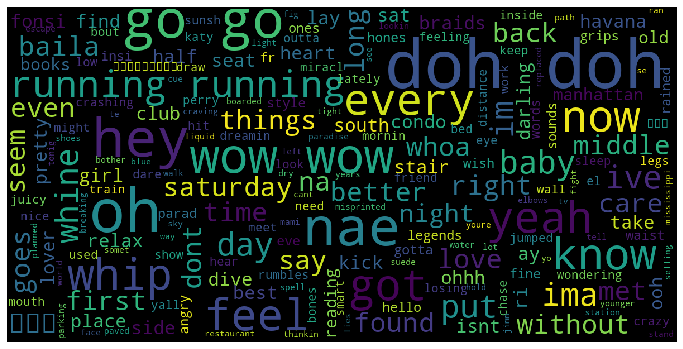

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(word_counts, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(word_counts))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(lyrics)

# Doc2Vec

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

# Bag Of Words

In [ ]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
X = df['clean_lyrics'] # the features we want to analyze
ylabels = df['class'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=72)

In [ ]:
classifier = LogisticRegression(solver="lbfgs")

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted, average=None))
print(" Recall:",metrics.recall_score(y_test, predicted, average=None))

In [ ]:
classifier = RandomForestClassifier(n_estimators=1000)

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted, average=None))
print(" Recall:",metrics.recall_score(y_test, predicted, average=None))

# Audio Features

In [ ]:
with open('../data/top_hits.json') as json_file:
    top_hits = json.load(json_file)

In [ ]:
top_hits_songs_df = pd.DataFrame(top_hits)